# Preprocessing

This code deals with the preprocessing of a ADS-B dataset, which was provided by 'The Opensky Network'.
The theory with which the preprocessing is based on, is described in my paper: 'Breitengrad Regression eines Flugzeugs mithilfe von ADS-B und Maschinellen Lernen'. The paper is to be found on the same git (Machine_Learning_with_ADS-B.pdf) but is only available in the german language. Some of the considerations are however once again given in a shortend form in the documentation of this notebook.

The general task is to reconstruct the position of the plane (latitude, longitude, geometric altitude) of a plane. Those information are given by a GPS and could be missing or faked. The barometric altitude is a information of the plane and is independently calculated of the GPS. Therefore it is available. The focus however is on reconstructing only the latitude. Everything would also work analogous to the other two features.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import json
import time
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import cos, arcsin, sqrt, pi
import os

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#load data 
#the ads-b data is stroed in a 'data' folder
load_folder = 'data/'
df = pd.read_csv(load_folder + 'training.csv', delimiter = ',')
sensors = pd.read_csv(load_folder + 'sensors.csv', delimiter = ',')

#save data
save_folder = 'processed/'
if not os.path.exists(save_folder[:-1]):
    os.makedirs(save_folder[:-1])

#give some information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002847 entries, 0 to 2002846
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               int64  
 1   timeAtServer     float64
 2   aircraft         int64  
 3   latitude         float64
 4   longitude        float64
 5   baroAltitude     float64
 6   geoAltitude      float64
 7   numMeasurements  int64  
 8   measurements     object 
dtypes: float64(5), int64(3), object(1)
memory usage: 137.5+ MB


In [2]:
#show dataframe of the ADS-B data
df.head()

,id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements
0,1,0.000,1013,48.365021,6.394888,11460.48,11849.10,2,"[[320,968413984,81],[129,968427734,28]]"
1,2,0.000,165,49.716393,9.597671,10668.00,10919.46,2,"[[320,973364296,56],[248,972777843,96]]"
2,3,0.000,2111,48.080795,6.242912,11894.82,12344.40,3,"[[320,973858546,37],[477,973712548,18],[440,97..."
3,4,0.000,893,46.813522,8.623732,11277.60,11689.08,4,"[[320,983214875,101],[206,983247062,98],[477,9..."
4,5,0.002,793,48.654602,9.129780,11277.60,11582.40,4,"[[294,992795640,68],[101,993231734,60],[440,99..."


In [3]:
#show the different amount of senors that have received an ADS-B signal
df.numMeasurements.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 12])

In [4]:
#show inavailabe datapoints
df.isna().sum()

id                     0
timeAtServer           0
aircraft               0
latitude           84735
longitude          84735
baroAltitude           0
geoAltitude        84735
numMeasurements        0
measurements           0
dtype: int64

In [5]:
#show information of the sensors
sensors.head()

,serial,latitude,longitude,height,type
0,1,46.681067,7.665313,680.9232,SBS-3
1,2,40.337042,-3.770206,735.7872,SBS-3
2,3,0.000000,0.000000,0.0000,SBS-3
3,4,47.143056,7.243889,550.1640,SBS-3
4,5,52.356455,4.952216,0.0000,dump1090


In [6]:
#show different senortypes
sensors.type.unique()

array(['SBS-3', 'dump1090', 'Radarcape', 'Asterix', 'Aero', 'GRX1090'],
      dtype=object)

In [7]:
#There are 2002847 data points in this dataset and 84735 columns have missing values.
#Those values do get dropped.
df = df.dropna()

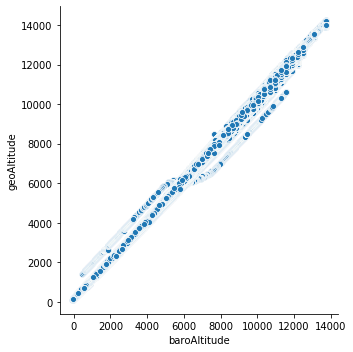

In [8]:
#showing the correlation of barometric and geometric altitude 
sns.relplot(x="baroAltitude", y="geoAltitude", data = df);

## Combining the ADS-B Dataframe with the Sensor Measurements

When considering a multilateration in a 3D space, you need at least 4 sensors for a accurate position localization.
However the barometric altitude and the geometric altitude have a huge correlation.
Therefore it is assumed that the problem can be reduced to a 2D problem with 3 sensors required.

There are different amounts of sensors that receive a ADS-B signal for each datapoint, the 'numMeasurements' is between 2 and 13. Most of them are in the lower range. For using a machine learning algorithm there needs to be a uniform processing of the measurements. Based on the consideration about multilateration, I suggest to accept only three measurements and only the first three, to enable an unbiased training. Each of the sensors have information about signal arrival time, amplitude, sensortype, geometric altitude, latitude and longitude. This leads to an amount of 18 features that can be substituted for the 'measurements' feature.

There are 6 different sensor types. Radarcape and GRX1090 are known to be responsible sensortypes.
Therefore those sensortypes are only considered. The ampltiude for Radarcape given in dB and for GRX1090 in percentage. Moreover the GRX1090 has some outlier in the percentage range. Those get dropped. Then both sensortypes get rescaled individually from 0 to 1. Afterwards, sensors with less than 0.02 rescaled amplitude are dropped.

In the end the (sensor-)'type', the 'aircraft', 'id' and the 'numMeasurements' feautres are dropped.

In [9]:
#measure time for this preprocessing step
start = time.time()
#it is possible to reduce the df to a smaller df, however is not done here
df_s = df
#prepare the array that gets converted to a new dataframe later
prepare_array = []
#make an iteration over the entire dataframe to further preprocess this
for i, row in df_s.iterrows():
    #only accept a num measurement of larger than 3
    if(row['numMeasurements']>=3):
        #rewrite the measurement list with json
        measurements_list = json.loads(row["measurements"])
        #prepare a row that gets appended later on the prepare array
        prepare_row = []
        #iterate over the three first measurements in the datapoint
        for k in range(3):
            #convert the measurement information
            m_list = measurements_list[k]
            #first entry is the index
            #the index in the 'measurements' list corresponds to the
            #index in the sensorslist, minus 1
            index = m_list[0]-1
            #arrival time of the signal is the second entry in the m_list
            arrival = m_list[1]
            #amplitude of the signal is the third entry in the m_list
            amplitude = m_list[2]
            #catch the information of the sensor
            sensor_row = sensors.iloc[index,:]
            #only accept 'Radarcape' or 'GRX1090' type sensors
            if(sensor_row['type'] == 'Radarcape' or sensor_row['type'] == 'GRX1090'):
                #add the information of the sensor
                prepare_row.append(sensor_row['type'])
                prepare_row.append(sensor_row['latitude'])
                prepare_row.append(sensor_row['longitude'])
                prepare_row.append(sensor_row['height'])
                prepare_row.append(arrival)
                prepare_row.append(amplitude)
                #only appends the row if there are actually 3 sensors accepted
                if(k==2):
                    #appending the other features
                    for j in row[0:8]:
                        prepare_row.append(j)
                    prepare_array.append(prepare_row)
            else:
                break
#ending the timer                
end = time.time()
print('It took %s seconds for filtering %s datapoints.'%(end - start, df_s.count()[0]))
print('There are now %s entries left.'%len(prepare_array))

It took 824.6918699741364 seconds for filtering 1918112 datapoints.
There are now 841203 entries left.


The previous code had only prepared an array. This is not translated into a pandas data frame.

In [10]:
#create a empty array, in which the names will be appended
names = []

#iterate over the first three sensors that measured the signal
for i in ['s1_','s2_','s3_']:
    #append the name of the data
    names.append(i+'type')
    names.append(i+'latitude')
    names.append(i+'longitude')
    names.append(i+'height')
    names.append(i+'arrival')
    names.append(i+'amplitude')

#take the first 9 column names of the dataframe
columns=df.columns[0:8]
#add additional column names
for i in columns:
    names.append(i)

#create a new dataframe
df_new = pd.DataFrame(prepare_array,columns=names)
#initiate a scaler from 0 to 1 for the amplitude of the individual sensortypes
scaler = MinMaxScaler()
for i in ['s1_', 's2_', 's3_']:
    #rescaling 'Radarcape'
    scaling_amp = scaler.fit_transform(df_new.loc[df_new[i+'type'] == 'Radarcape'][[i+'amplitude']])
    df_new.loc[df_new[i+'type'] == 'Radarcape',i+'amplitude'] = scaling_amp
    #The 'GRX1090' data with the outliners are removed here
    index_names = df_new[df_new[i+'amplitude'] > 100].index
    df_new.drop(index_names , inplace=True)
    #rescaling 'GRX1090'
    scaling_amp = scaler.fit_transform(df_new.loc[df_new[i+'type'] == 'GRX1090'][[i+'amplitude']])
    df_new.loc[df_new[i+'type'] == 'GRX1090',i+'amplitude'] = scaling_amp 
    #drop the sensor-'type'
    df_new = df_new.drop([i+'type'], axis =1)
    #drop amplitudes which are smaller than 0.02 for each sensor
    index_names = df_new[df_new[i+'amplitude'] < 0.02].index
    df_new.drop(index_names , inplace=True)

#drop the 'id' feature
df_new = df_new.drop(['id'], axis =1)
#drop the 'aircraft' feature
df_new = df_new.drop(['aircraft'], axis =1)
#drop the 'numMeasurements' feature
df_new = df_new.drop(['numMeasurements'], axis =1)

In [11]:
#saving to csv
df_new.to_csv(save_folder + 'df.csv')

## Preprocessing Visualisation

Now the data preprocessing is done and some further correlations are visualized for the data:

In [12]:
#statistical description of the dataset
df_new.describe()

,s1_latitude,s1_longitude,s1_height,s1_arrival,s1_amplitude,s2_latitude,s2_longitude,s2_height,s2_arrival,s2_amplitude,s3_latitude,s3_longitude,s3_height,s3_arrival,s3_amplitude,timeAtServer,latitude,longitude,baroAltitude,geoAltitude
count,771077.000000,771077.000000,771077.000000,7.710770e+05,771077.000000,771077.000000,771077.000000,771077.000000,7.710770e+05,771077.000000,771077.000000,771077.000000,771077.000000,7.710770e+05,771077.000000,771077.000000,771077.000000,771077.000000,771077.000000,771077.000000
mean,49.229587,8.108717,274.211906,1.784512e+12,0.317959,49.207144,8.220022,330.849877,1.784513e+12,0.318877,49.170290,8.240812,371.571721,1.784512e+12,0.329877,1783.531856,49.196764,8.012473,9567.220516,9832.390680
std,1.935346,2.907224,251.859486,1.047265e+12,0.135479,1.893723,2.805626,308.517242,1.047265e+12,0.139309,1.823613,2.686093,349.585577,1.047261e+12,0.140920,1047.264856,1.900330,2.778327,2605.998223,2654.560364
min,41.855279,-7.188814,-1.820427,9.628652e+08,0.020833,38.103681,-7.188814,-1.820427,9.628016e+08,0.020661,38.103681,-7.188814,-1.820427,9.632462e+08,0.020833,0.000000,41.103205,-4.656477,0.000000,228.600000
25%,47.347179,6.837746,89.977486,8.661639e+11,0.214286,47.377785,7.353797,82.381000,8.661637e+11,0.214876,47.400170,7.353797,82.381000,8.661636e+11,0.228448,865.183000,47.698929,6.685730,8801.100000,9006.840000
50%,50.048573,8.487752,223.256345,1.779370e+12,0.310924,49.529678,8.487752,273.985000,1.779370e+12,0.309917,49.471601,8.358244,302.881989,1.779370e+12,0.322917,1778.398000,49.517569,8.270493,10668.000000,10904.220000
75%,51.242813,8.641771,481.115997,2.694844e+12,0.415966,50.937081,8.789325,497.984192,2.694843e+12,0.413223,50.937081,8.789325,497.984192,2.694843e+12,0.422414,2693.863000,50.633891,9.510005,11277.600000,11582.400000
max,53.469921,16.371110,1699.392950,3.600960e+12,1.000000,53.469921,16.877839,1699.392950,3.600960e+12,1.000000,53.469921,16.877839,1699.392950,3.600960e+12,1.000000,3599.971000,56.079163,16.791933,13731.240000,14226.540000


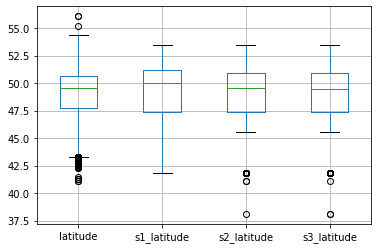

In [13]:
#boxplot of the latitude of the aircraft and the sensors
df_new[['latitude','s1_latitude','s2_latitude','s3_latitude']].boxplot()

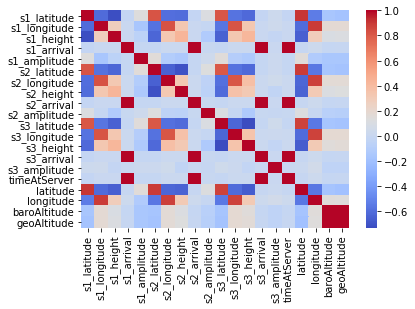

In [14]:
#correlation map of all the features
sns.heatmap(df_new.corr(), cmap='coolwarm')

[(0, 0.8)]

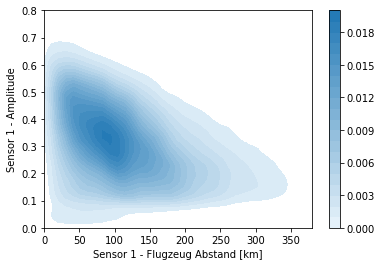

In [15]:
#the following plot is a little bit more complicated
#the distance of the plane to the first sensor is plotted with the amplitude of this signal
#since the position is given as latitude, longitude and altitude, this needs to be converted into distance

#the following formulas can be derived from here:
#http://edwilliams.org/avform.htm

def distance(lat1, lon1, lat2, lon2):
    p = pi/180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 12742 * arcsin(sqrt(a)) #2*R*asin...

#once again the dataframe can be here set to a smaller df to speed up the process, but is not done
df_test = df_new
test = pd.DataFrame
#distance dependent of the longitude and latitude
dist = distance(df_test['latitude'],df_test['longitude'],df_test['s1_latitude'],df_test['s1_longitude'])
#with the pythagorean theorem and the geometric altitude difference
dist = sqrt((dist * dist) + (((df_test['geoAltitude']-df_test['s1_height'])/1000)**2))
#further code for plotting purposes
test =  pd.DataFrame(dist,columns=['Sensor 1 - Flugzeug Abstand [km]'])
test['Sensor 1 - Amplitude'] = df_test['s1_amplitude']
fig = sns.kdeplot(data=test[test.columns[0]], data2=test[test.columns[1]],
            n_levels=20, cbar=True, shade=  True, kernel = 'biw', shade_lowest = 0)
fig.set(xlim=(0,380))
fig.set(ylim=(0,0.8))

## Discussion Notes

It is to note that most of the aircraft in the dataframe are in a close by region of 41.8 to 53.5 degree in latitude. Therefore any learning procedure on such a dataset is questionable to work universally, since it is here only tested in this range. Also the position of the aircraft is highly correlated to the position of the sensors.

Moreover it is interesting that the distance and the amplitude has a huge variance. Therefore the time of the arrival and the server time might be important features for a distance / position calculation. The speed of the signal is always transmitted with the speed of light and could be calculated with the time difference.